Analyzing overall recall and specificity across 10 test folds
Using macro-averaging (unweighted mean of per-class values)


OVERALL RECALL TABLE (mean ± std)
     Model Overall Recall
 FS_PCA_NN  0.850 ± 0.031
FS_PCA_SVM  0.882 ± 0.025
        RF  0.862 ± 0.033
FS_PCA_QDA  0.876 ± 0.021
FS_PCA_KNN  0.865 ± 0.023
 FS_PCA_LR  0.827 ± 0.042

OVERALL SPECIFICITY TABLE (mean ± std)
     Model Overall Specificity
 FS_PCA_NN       0.975 ± 0.005
FS_PCA_SVM       0.980 ± 0.004
        RF       0.977 ± 0.005
FS_PCA_QDA       0.979 ± 0.004
FS_PCA_KNN       0.977 ± 0.004
 FS_PCA_LR       0.971 ± 0.007

COMBINED TABLE: OVERALL RECALL AND SPECIFICITY
     Model Recall (mean ± std) Specificity (mean ± std)
 FS_PCA_NN       0.850 ± 0.031            0.975 ± 0.005
FS_PCA_SVM       0.882 ± 0.025            0.980 ± 0.004
        RF       0.862 ± 0.033            0.977 ± 0.005
FS_PCA_QDA       0.876 ± 0.021            0.979 ± 0.004
FS_PCA_KNN       0.865 ± 0.023            0.977 ± 0.004
 FS_PCA_LR       0.

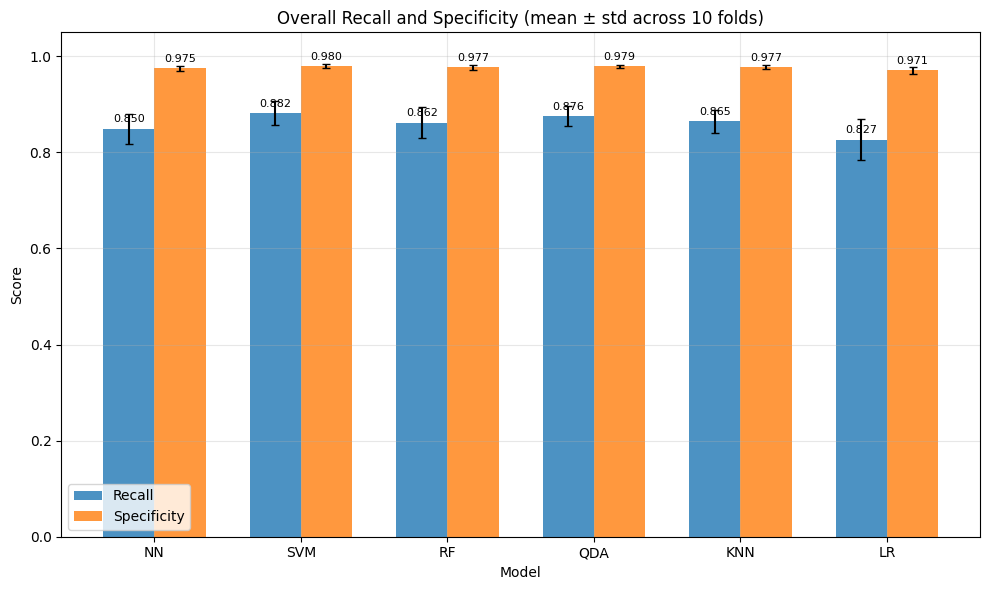

In [1]:
#!/usr/bin/env python3
"""
Overall Recall and Specificity Analysis
Calculates overall recall and specificity from per-class metrics
"""

import numpy as np
import pandas as pd
import os

# Configuration
OUTPUT_ROOT = 'output'
METRICS_DIR = os.path.join(OUTPUT_ROOT, 'metrics')
MODEL_SET = ['FS_PCA_NN', 'FS_PCA_SVM', 'RF', 'FS_PCA_QDA', 'FS_PCA_KNN', 'FS_PCA_LR']

# Auto-detect number of folds
def detect_n_folds():
    """Detect the actual number of folds from available files"""
    if not os.path.exists(METRICS_DIR):
        return 5
    
    max_fold = 0
    for model in MODEL_SET:
        fold = 1
        while os.path.exists(os.path.join(METRICS_DIR, f"per_class_recall_{model}_{fold}.npy")):
            max_fold = max(max_fold, fold)
            fold += 1
    return max_fold if max_fold > 0 else 5

N_FOLDS = detect_n_folds()

def calculate_overall_metrics_from_per_class():
    """
    Calculate overall recall and specificity from per-class metrics
    Using macro-averaging (unweighted mean of per-class values)
    """
    results = {}
    
    for model_name in MODEL_SET:
        recalls = []
        specificities = []
        
        # Load data from all folds
        for fold_idx in range(1, N_FOLDS + 1):
            # Load per-class recall
            recall_file = f"per_class_recall_{model_name}_{fold_idx}.npy"
            recall_path = os.path.join(METRICS_DIR, recall_file)
            
            # Load per-class specificity
            spec_file = f"per_class_specificity_{model_name}_{fold_idx}.npy"
            spec_path = os.path.join(METRICS_DIR, spec_file)
            
            if os.path.exists(recall_path) and os.path.exists(spec_path):
                per_class_recall = np.load(recall_path)
                per_class_spec = np.load(spec_path)
                
                # Calculate macro-averaged values for this fold
                overall_recall = np.mean(per_class_recall)
                overall_spec = np.mean(per_class_spec)
                
                recalls.append(overall_recall)
                specificities.append(overall_spec)
        
        if recalls:
            # Calculate mean and std across folds
            recall_mean = np.mean(recalls)
            recall_std = np.std(recalls)
            spec_mean = np.mean(specificities)
            spec_std = np.std(specificities)
            
            results[model_name] = {
                'recall_mean': recall_mean,
                'recall_std': recall_std,
                'specificity_mean': spec_mean,
                'specificity_std': spec_std,
                'recall_values': np.array(recalls),
                'specificity_values': np.array(specificities)
            }
            
            # Save numpy arrays
            np.save(f"{model_name}_overall_recall_mean.npy", recall_mean)
            np.save(f"{model_name}_overall_recall_std.npy", recall_std)
            np.save(f"{model_name}_overall_specificity_mean.npy", spec_mean)
            np.save(f"{model_name}_overall_specificity_std.npy", spec_std)
    
    return results

def calculate_weighted_metrics():
    """
    Calculate weighted-average recall and specificity
    This accounts for class imbalance
    """
    # First, we need to load accuracy values to understand class distributions
    # We'll use confusion matrices if available
    
    weighted_results = {}
    
    print("\nNote: For weighted averages, we would need class sample counts.")
    print("Using macro-averaged values as the primary metric.\n")
    
    return weighted_results

def create_formatted_tables(results):
    """
    Create formatted tables for recall and specificity
    """
    # Table 1: Overall Recall
    print("\n" + "="*80)
    print("OVERALL RECALL TABLE (mean ± std)")
    print("="*80)
    
    recall_data = []
    headers = ['Model', 'Overall Recall']
    
    for model_name in MODEL_SET:
        if model_name in results:
            mean_val = results[model_name]['recall_mean']
            std_val = results[model_name]['recall_std']
            recall_data.append([model_name, f"{mean_val:.3f} ± {std_val:.3f}"])
    
    recall_df = pd.DataFrame(recall_data, columns=headers)
    print(recall_df.to_string(index=False))
    recall_df.to_csv('overall_recall_table.csv', index=False)
    
    # Table 2: Overall Specificity
    print("\n" + "="*80)
    print("OVERALL SPECIFICITY TABLE (mean ± std)")
    print("="*80)
    
    spec_data = []
    headers = ['Model', 'Overall Specificity']
    
    for model_name in MODEL_SET:
        if model_name in results:
            mean_val = results[model_name]['specificity_mean']
            std_val = results[model_name]['specificity_std']
            spec_data.append([model_name, f"{mean_val:.3f} ± {std_val:.3f}"])
    
    spec_df = pd.DataFrame(spec_data, columns=headers)
    print(spec_df.to_string(index=False))
    spec_df.to_csv('overall_specificity_table.csv', index=False)
    
    # Combined table
    print("\n" + "="*80)
    print("COMBINED TABLE: OVERALL RECALL AND SPECIFICITY")
    print("="*80)
    
    combined_data = []
    headers = ['Model', 'Recall (mean ± std)', 'Specificity (mean ± std)']
    
    for model_name in MODEL_SET:
        if model_name in results:
            recall_mean = results[model_name]['recall_mean']
            recall_std = results[model_name]['recall_std']
            spec_mean = results[model_name]['specificity_mean']
            spec_std = results[model_name]['specificity_std']
            
            combined_data.append([
                model_name,
                f"{recall_mean:.3f} ± {recall_std:.3f}",
                f"{spec_mean:.3f} ± {spec_std:.3f}"
            ])
    
    combined_df = pd.DataFrame(combined_data, columns=headers)
    print(combined_df.to_string(index=False))
    combined_df.to_csv('overall_recall_specificity_table.csv', index=False)
    
    # Create clean version with short model names
    model_name_map = {
        'FS_PCA_NN': 'NN',
        'FS_PCA_SVM': 'SVM',
        'RF': 'RF',
        'FS_PCA_QDA': 'QDA',
        'FS_PCA_KNN': 'KNN',
        'FS_PCA_LR': 'LR'
    }
    
    clean_data = []
    for row in combined_data:
        clean_row = [model_name_map.get(row[0], row[0]), row[1], row[2]]
        clean_data.append(clean_row)
    
    clean_df = pd.DataFrame(clean_data, columns=['Model', 'Recall', 'Specificity'])
    
    print("\n" + "="*70)
    print("CLEAN FORMAT TABLE")
    print("="*70)
    print(clean_df.to_string(index=False))
    clean_df.to_csv('overall_metrics_clean.csv', index=False)

def plot_metrics(results):
    """
    Create visualization of overall metrics
    """
    try:
        import matplotlib.pyplot as plt
        
        models = []
        recall_means = []
        recall_stds = []
        spec_means = []
        spec_stds = []
        
        for model_name in MODEL_SET:
            if model_name in results:
                models.append(model_name.replace('FS_PCA_', ''))
                recall_means.append(results[model_name]['recall_mean'])
                recall_stds.append(results[model_name]['recall_std'])
                spec_means.append(results[model_name]['specificity_mean'])
                spec_stds.append(results[model_name]['specificity_std'])
        
        x = np.arange(len(models))
        width = 0.35
        
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Plot bars
        rects1 = ax.bar(x - width/2, recall_means, width, yerr=recall_stds, 
                        label='Recall', capsize=3, alpha=0.8)
        rects2 = ax.bar(x + width/2, spec_means, width, yerr=spec_stds,
                        label='Specificity', capsize=3, alpha=0.8)
        
        # Customize plot
        ax.set_xlabel('Model')
        ax.set_ylabel('Score')
        ax.set_title(f'Overall Recall and Specificity (mean ± std across {N_FOLDS} folds)')
        ax.set_xticks(x)
        ax.set_xticklabels(models)
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 1.05)
        
        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(rect.get_x() + rect.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom',
                           fontsize=8)
        
        autolabel(rects1)
        autolabel(rects2)
        
        plt.tight_layout()
        plt.savefig('overall_metrics_comparison.png', dpi=300, bbox_inches='tight')
        print("\nPlot saved as 'overall_metrics_comparison.png'")
        
    except ImportError:
        print("\nMatplotlib not available, skipping visualization")

def main():
    print(f"Analyzing overall recall and specificity across {N_FOLDS} test folds")
    print("Using macro-averaging (unweighted mean of per-class values)\n")
    
    # Calculate overall metrics
    results = calculate_overall_metrics_from_per_class()
    
    if not results:
        print("Error: No results calculated. Please check the output folder.")
        return
    
    # Create formatted tables
    create_formatted_tables(results)
    
    # Create visualization
    plot_metrics(results)
    
    # Summary
    print("\n" + "="*80)
    print("SUMMARY")
    print("="*80)
    print(f"Total models analyzed: {len(results)}")
    print(f"Test folds: {N_FOLDS}")
    print(f"\nSaved files:")
    print("- 24 numpy arrays: {model}_overall_{metric}_{stat}.npy")
    print("  where metric = recall/specificity, stat = mean/std")
    print("- overall_recall_table.csv")
    print("- overall_specificity_table.csv")
    print("- overall_recall_specificity_table.csv")
    print("- overall_metrics_clean.csv")
    print("- overall_metrics_comparison.png (if matplotlib available)")
    
    # Best models
    print("\n" + "="*80)
    print("BEST MODELS")
    print("="*80)
    
    # Best recall
    best_recall_model = max(results.items(), key=lambda x: x[1]['recall_mean'])
    print(f"Best Overall Recall: {best_recall_model[0]} ({best_recall_model[1]['recall_mean']:.3f} ± {best_recall_model[1]['recall_std']:.3f})")
    
    # Best specificity
    best_spec_model = max(results.items(), key=lambda x: x[1]['specificity_mean'])
    print(f"Best Overall Specificity: {best_spec_model[0]} ({best_spec_model[1]['specificity_mean']:.3f} ± {best_spec_model[1]['specificity_std']:.3f})")
    
    # Most balanced (smallest difference between recall and specificity)
    balance_scores = {}
    for model, metrics in results.items():
        diff = abs(metrics['recall_mean'] - metrics['specificity_mean'])
        balance_scores[model] = diff
    
    most_balanced = min(balance_scores.items(), key=lambda x: x[1])
    print(f"Most Balanced Model: {most_balanced[0]} (|Recall - Specificity| = {most_balanced[1]:.3f})")

if __name__ == "__main__":
    main()